In [1]:
import os
# import cv2
import six
import time
import math
import torch
import random
import numbers
import warnings
import collections
import torchvision
import numpy as np
from torch import nn
from PIL import Image
# from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from torch.nn import init
from PIL import ImageOps
import scipy.misc as misc
from torch.utils import data
from datetime import datetime
import torch.nn.functional as F
from __future__ import division
from torch.autograd import Variable
from torch.optim import lr_scheduler
from collections import OrderedDict
import torchvision.transforms as tfs
# from tensorboardX import SummaryWriter
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings("ignore")

from torchvision.transforms import ToTensor, ToPILImage
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, Pad

# from functools import partial
# try:
#     import pydensecrf.densecrf as dcrf
# except:
#     print("Failed to import pydensecrf, CRF post-processing will not work")
#from torch.nn import functional as F

In [2]:
torch.__version__

'0.3.0b0+591e73e'

In [3]:
#超参数
args = {
    'batch_size': 4,
    'train_shuffle':True,
    'val_shuffle':False,
#     'crop_ratio':0.875,
    'crop_ratio':1,
#     'up_lr':0.005,
    'prcnt':10,
    'learn_rate':0.005,
    'use_cycle' :True,
#     'low_lr': 5e-4,
    'num_classes':19,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'epoch_num': 200,
    'curr_epoch':1,
    'best_iou' : -100.0,
    'start_epoch': 0,
    'resume' : None,
#     'resume' : 'Cityscapes_mobilev2_best_model.pkl',
    'pre_trained' : None,
    'dataset' : 'Cityscapes',
    'local_path' : 'E:/Cityscapes',
    'save_root': 'E:/AnacondaProject/data/hjk_project/biye/biye3'
}

In [4]:
#数据增强处理
class Compose(object):
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, img, mask):
        img, mask = Image.fromarray(img, mode='RGB'), Image.fromarray(mask, mode='L')
        assert img.size == mask.size

        for a in self.augmentations:
            img, mask = a(img, mask)
        return np.array(img, dtype=np.uint8), np.array(mask, dtype=np.uint8)

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):
        if self.padding > 0:
            img = ImageOps.expand(img, border=self.padding, fill=0)
            mask = ImageOps.expand(mask, border=self.padding, fill=0)

        assert img.size == mask.size

        w, h = img.size
        th, tw = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

class CenterCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask):
        if random.random() < 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

class FreeScale(object):
    def __init__(self, size):
        self.size = tuple(reversed(size))  # size: (h, w)

    def __call__(self, img, mask):
        assert img.size == mask.size
        return img.resize(self.size, Image.BILINEAR), mask.resize(self.size, Image.NEAREST)

class Scale(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        w, h = img.size
        if (w >= h and w == self.size[1]) or (h >= w and h == self.size[0]):
            return img, mask

        oh, ow = self.size
        return img.resize((ow, oh), Image.BILINEAR), mask.resize((ow, oh), Image.NEAREST)

class RandomSizedCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, img, mask):
        assert img.size == mask.size
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.45, 1.0) * area
            aspect_ratio = random.uniform(0.5, 2)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                mask = mask.crop((x1, y1, x1 + w, y1 + h))
                assert (img.size == (w, h))

                return img.resize((self.size, self.size), Image.BILINEAR), mask.resize((self.size, self.size),
                                                                                       Image.NEAREST)

        scale = Scale(self.size)
        crop = CenterCrop(self.size)
        return crop(*scale(img, mask))

class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree

    def __call__(self, img, mask):
        rotate_degree = random.random() * 2 * self.degree - self.degree
        return img.rotate(rotate_degree, Image.BILINEAR), mask.rotate(rotate_degree, Image.NEAREST)

class RandomSized(object):
    def __init__(self, limit):
        self.limit = limit

    def __call__(self, img, mask):

        scale = random.uniform(self.limit[0], self.limit[1])
        w = int(scale * img.size[0])
        h = int(scale * img.size[1])

        img, mask = img.resize((w, h), Image.BILINEAR), mask.resize((w, h), Image.NEAREST)

        return img, mask

In [5]:
#数据的载入
def recursive_glob(rootdir='.', suffix=''):
    return [os.path.join(looproot, filename)
            for looproot, _, filenames in os.walk(rootdir)
            for filename in filenames if filename.endswith(suffix)]

class CityscapesLoader(data.Dataset):

    colors = [  
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32]
#         [0, 0, 0]
            ]

    label_colours = dict(zip(range(19), colors))

    def __init__(self, root, split="train", gt="gtCoarse", img_size=(512, 1024),
                 is_transform=False, augmentations=None):
    
        self.root = root
        self.gt = gt
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations

        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.mean = np.array([73.16, 82.91, 72.39])
        self.files = {}

        self.images_base = os.path.join(self.root, 'leftImg8bit', self.split)
        self.annotations_base = os.path.join(self.root, gt, self.split)

        self.files[split] = recursive_glob(rootdir=self.images_base, suffix='.png')

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence',
                            'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain',
                            'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
                            'motorcycle', 'bicycle']

        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))

        if not self.files[split]:
            raise Exception("> No files for split=[%s] found in %s" % (split, self.images_base))

        print("> Found %d %s images..." % (len(self.files[split]), split))

    def __len__(self):
    
        return len(self.files[self.split])

    def __getitem__(self, index):
       
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(self.annotations_base,
                                img_path.split(os.sep)[-2],
                                os.path.basename(img_path)[:-15] + '{}_labelIds.png'.format(self.gt))

        if not os.path.isfile(img_path) or not os.path.exists(img_path):
            raise Exception("{} is not a file, can not open with imread.".format(img_path))

        img = misc.imread(img_path)
        img = np.array(img, dtype=np.uint8)
        # img = misc.imresize(img, (self.img_size[0], self.img_size[1], "bilinear"))

        if not os.path.isfile(lbl_path) or not os.path.exists(lbl_path):
            raise Exception("{} is not a file, can not open with imread.".format(lbl_path))

        lbl = misc.imread(lbl_path)
        
        # lbl = misc.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode='F')
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.augmentations is not None:
            img, lbl = self.augmentations(img, lbl)

        if self.is_transform:
            img, lbl = self.transform(img, lbl)

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        return img, lbl

    def transform(self, img, lbl):
        
        img = img[:, :, ::-1]         # From RGB to BGR
        img = img.astype(float)
        img -= self.mean
        img /= 255.0
        img = img.transpose(2, 0, 1)  # From H*W*C to C*H*W

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            raise ValueError("> Segmentation map contained invalid class values.")

        return img, lbl

    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def encode_segmap(self, mask):
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

In [6]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 1. Load Data
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
height, width = int(512*args['crop_ratio']), int(1024*args['crop_ratio'])

augment_train = Compose([RandomHorizontallyFlip(), RandomSized((0.5, 1.5)),
                   RandomRotate(3), RandomCrop((height, width))])

# augment_valid = Compose([Scale((512, 1024)),CenterCrop((height, width))])

augment_valid = Compose([ Scale((1024, 2048)), CenterCrop((1024, 2048))])

train_data = CityscapesLoader(args['local_path'], split="train", gt="gtFine", is_transform=True, augmentations=augment_train)
valid_data = CityscapesLoader(args['local_path'], split="val", gt="gtFine", is_transform=True, augmentations=augment_valid)

train_loader = DataLoader(train_data,  batch_size=args["batch_size"], shuffle= args["train_shuffle"] )
valid_loader = DataLoader(valid_data,  batch_size=1, shuffle= args["val_shuffle"] )

> Found 2975 train images...
> Found 500 val images...


In [7]:
len(train_loader),len(valid_loader)

(744, 500)

In [8]:
train_data[0]

(
 ( 0  ,.,.) = 
   0.0307  0.0229  0.0229  ...  -0.1144 -0.1222 -0.1300
   0.0817  0.0778  0.0778  ...  -0.1183 -0.1183 -0.1261
   0.0935  0.1013  0.1131  ...  -0.1222 -0.1222 -0.1261
            ...             ⋱             ...          
  -0.0163 -0.0163 -0.0085  ...  -0.0359 -0.0359 -0.0398
  -0.0085 -0.0124 -0.0045  ...  -0.0398 -0.0359 -0.0359
  -0.0085 -0.0085 -0.0006  ...  -0.0398 -0.0359 -0.0320
 
 ( 1  ,.,.) = 
   0.0513  0.0435  0.0396  ...  -0.1134 -0.1173 -0.1212
   0.1102  0.1023  0.0945  ...  -0.1134 -0.1134 -0.1173
   0.1141  0.1180  0.1219  ...  -0.1173 -0.1173 -0.1173
            ...             ⋱             ...          
   0.0082  0.0043  0.0082  ...  -0.0349 -0.0389 -0.0389
   0.0160  0.0121  0.0160  ...  -0.0389 -0.0389 -0.0389
   0.0160  0.0160  0.0160  ...  -0.0389 -0.0389 -0.0389
 
 ( 2  ,.,.) = 
   0.0495  0.0416  0.0338  ...  -0.0878 -0.0917 -0.0956
   0.1122  0.1004  0.0965  ...  -0.0878 -0.0878 -0.0917
   0.1083  0.1122  0.1200  ...  -0.0878 -0.0878 -0.09

In [9]:
valid_data[0]

(
 ( 0  ,.,.) = 
  -0.0555 -0.0516 -0.0438  ...   0.1327  0.0935 -0.2869
   0.2935  0.2778  0.2660  ...   0.1288  0.0935 -0.2869
   0.1876  0.1798  0.1758  ...   0.1249  0.0935 -0.2791
            ...             ⋱             ...          
   0.0856  0.0856  0.0974  ...   0.0700  0.0700  0.0700
   0.0856  0.0856  0.0974  ...  -0.1771  0.0582  0.0582
   0.0856  0.0896  0.0974  ...  -0.1693 -0.1732 -0.1771
 
 ( 1  ,.,.) = 
   0.0553  0.0592  0.0631  ...   0.2004  0.1651 -0.0977
   0.3886  0.3768  0.3611  ...   0.1964  0.1651 -0.0938
   0.3337  0.3219  0.3141  ...   0.1925  0.1651 -0.0859
            ...             ⋱             ...          
   0.0788  0.0827  0.0945  ...   0.0709  0.0709  0.0709
   0.0788  0.0827  0.0945  ...  -0.2036  0.0592  0.0592
   0.0788  0.0827  0.0945  ...  -0.1996 -0.2036 -0.2075
 
 ( 2  ,.,.) = 
   0.0377  0.0416  0.0455  ...   0.1004  0.1318  0.1083
   0.4102  0.3945  0.3789  ...   0.1004  0.1357  0.1083
   0.3436  0.3357  0.3240  ...   0.1004  0.1396  0.10

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


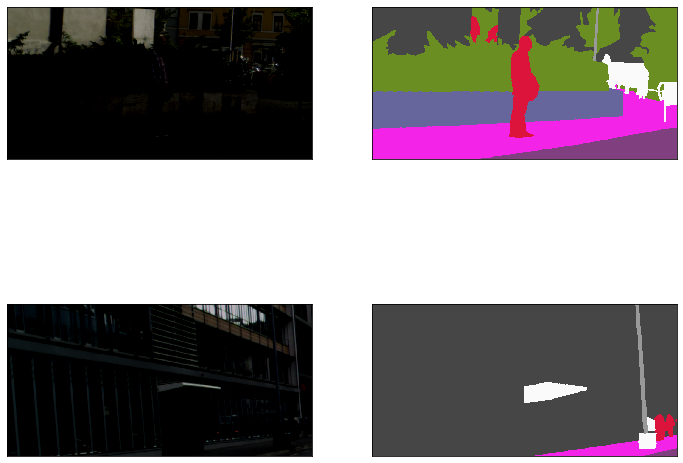

In [10]:
#可视化输入数据和标签
for i, datas in enumerate(train_loader):
    if i == 1:
        break
    else:
        imgs, labels = datas
        imgs = imgs.numpy()[:, ::-1, :, :]
        imgs = np.transpose(imgs, [0,2,3,1])
        f, axarr = plt.subplots(2, 2, figsize=(12, 10))
        for j in range(2):      
            axarr[j][0].imshow(imgs[j])
            axarr[j][0].axes.get_xaxis().set_visible(False)
            axarr[j][0].axes.get_yaxis().set_visible(False)
            axarr[j][1].imshow(train_data.decode_segmap(labels.numpy()[j]))
            axarr[j][1].axes.get_xaxis().set_visible(False)
            axarr[j][1].axes.get_yaxis().set_visible(False)
        plt.show()

In [11]:
up_kwargs = {'mode': 'bilinear', 'align_corners': True}

torch_ver = torch.__version__[:3]

__all__ = ['GlobalAvgPool2d', 'GramMatrix',
           'View', 'Sum', 'Mean', 'Normalize', 'ConcurrentModule',
           'PyramidPooling', 'StripPooling']

class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return F.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)



class GramMatrix(nn.Module):
    r""" Gram Matrix for a 4D convolutional featuremaps as a mini-batch

    .. math::
        \mathcal{G} = \sum_{h=1}^{H_i}\sum_{w=1}^{W_i} \mathcal{F}_{h,w}\mathcal{F}_{h,w}^T
    """
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram

class View(nn.Module):
    """Reshape the input into different size, an inplace operator, support
    SelfParallel mode.
    """
    def __init__(self, *args):
        super(View, self).__init__()
        if len(args) == 1 and isinstance(args[0], torch.Size):
            self.size = args[0]
        else:
            self.size = torch.Size(args)

    def forward(self, input):
        return input.view(self.size)


class Sum(nn.Module):
    def __init__(self, dim, keep_dim=False):
        super(Sum, self).__init__()
        self.dim = dim
        self.keep_dim = keep_dim

    def forward(self, input):
        return input.sum(self.dim, self.keep_dim)


class Mean(nn.Module):
    def __init__(self, dim, keep_dim=False):
        super(Mean, self).__init__()
        self.dim = dim
        self.keep_dim = keep_dim

    def forward(self, input):
        return input.mean(self.dim, self.keep_dim)


class Normalize(nn.Module):
    r"""Performs :math:`L_p` normalization of inputs over specified dimension.

    Does:

    .. math::
        v = \frac{v}{\max(\lVert v \rVert_p, \epsilon)}

    for each subtensor v over dimension dim of input. Each subtensor is
    flattened into a vector, i.e. :math:`\lVert v \rVert_p` is not a matrix
    norm.

    With default arguments normalizes over the second dimension with Euclidean
    norm.

    Args:
        p (float): the exponent value in the norm formulation. Default: 2
        dim (int): the dimension to reduce. Default: 1
    """
    def __init__(self, p=2, dim=1):
        super(Normalize, self).__init__()
        self.p = p
        self.dim = dim

    def forward(self, x):
        return F.normalize(x, self.p, self.dim, eps=1e-8)

class ConcurrentModule(nn.ModuleList):
    r"""Feed to a list of modules concurrently. 
    The outputs of the layers are concatenated at channel dimension.

    Args:
        modules (iterable, optional): an iterable of modules to add
    """
    def __init__(self, modules=None):
        super(ConcurrentModule, self).__init__(modules)

    def forward(self, x):
        outputs = []
        for layer in self:
            outputs.append(layer(x))
        return torch.cat(outputs, 1)

class SPBlock(nn.Module):
    def __init__(self, inplanes, outplanes, norm_layer, k_size, padding):
        super(SPBlock, self).__init__()
        midplanes = outplanes
        #self.conv1 = nn.Conv2d(inplanes, midplanes, kernel_size=(3, 1), padding=(1, 0), bias=False)
        self.conv1 = nn.Conv2d(inplanes, midplanes, kernel_size=(k_size, 1), padding=(padding, 0), bias=False, groups=inplanes)
        self.bn1 = norm_layer(midplanes)
        #self.conv2 = nn.Conv2d(inplanes, midplanes, kernel_size=(1, 3), padding=(0, 1), bias=False)
        self.conv2 = nn.Conv2d(inplanes, midplanes, kernel_size=(1, k_size), padding=(0, padding), bias=False, groups=inplanes)
        self.bn2 = norm_layer(midplanes)
        self.conv3 = nn.Conv2d(midplanes, outplanes, kernel_size=1, bias=True, groups=midplanes)
        self.pool1 = nn.AdaptiveAvgPool2d((None, 1))
        self.pool2 = nn.AdaptiveAvgPool2d((1, None))
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        _, _, h, w = x.size()
        x1 = self.pool1(x)
        x1 = self.conv1(x1)
        x1 = self.bn1(x1)
        x1 = x1.expand(-1, -1, h, w)
        #x1 = F.interpolate(x1, (h, w))

        x2 = self.pool2(x)
        x2 = self.conv2(x2)
        x2 = self.bn2(x2)
        x2 = x2.expand(-1, -1, h, w)
        #x2 = F.interpolate(x2, (h, w))

        x = self.relu(x1 + x2)
        x = self.conv3(x).sigmoid()
        return x    
    
class PyramidPooling(nn.Module):
    """
    Reference:
        Zhao, Hengshuang, et al. *"Pyramid scene parsing network."*
    """
    def __init__(self, in_channels, norm_layer, up_kwargs):
        super(PyramidPooling, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(1)
        self.pool2 = nn.AdaptiveAvgPool2d(2)
        self.pool3 = nn.AdaptiveAvgPool2d(3)
        self.pool4 = nn.AdaptiveAvgPool2d(6)

        out_channels = int(in_channels/4)
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                norm_layer(out_channels),
                                nn.ReLU(True))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                norm_layer(out_channels),
                                nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                norm_layer(out_channels),
                                nn.ReLU(True))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False),
                                norm_layer(out_channels),
                                nn.ReLU(True))
        # bilinear interpolate options
        self._up_kwargs = up_kwargs

    def forward(self, x):
        _, _, h, w = x.size()
        feat1 = F.upsample(self.conv1(self.pool1(x)), (h, w), **self._up_kwargs)
        feat2 = F.upsample(self.conv2(self.pool2(x)), (h, w), **self._up_kwargs)
        feat3 = F.upsample(self.conv3(self.pool3(x)), (h, w), **self._up_kwargs)
        feat4 = F.upsample(self.conv4(self.pool4(x)), (h, w), **self._up_kwargs)
        return torch.cat((x, feat1, feat2, feat3, feat4), 1)

class StripPooling(nn.Module):
    """
    Reference:
    """
    def __init__(self, in_channels, pool_size, norm_layer, up_kwargs):
        super(StripPooling, self).__init__()
        self.pool1 = nn.AdaptiveAvgPool2d(pool_size[0])
        self.pool2 = nn.AdaptiveAvgPool2d(pool_size[1])
        self.pool3 = nn.AdaptiveAvgPool2d((1, None))
        self.pool4 = nn.AdaptiveAvgPool2d((None, 1))

        inter_channels = int(in_channels/4)
        self.conv1_1 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 1, bias=False),
                                norm_layer(inter_channels),
                                nn.ReLU(True))
        self.conv1_2 = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 1, bias=False),
                                norm_layer(inter_channels),
                                nn.ReLU(True))
        self.conv2_0 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False, groups=inter_channels),
                                norm_layer(inter_channels))
        self.conv2_1 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False, groups=inter_channels),
                                norm_layer(inter_channels))
        self.conv2_2 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False, groups=inter_channels),
                                norm_layer(inter_channels))
        self.conv2_3 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, (1, 3), 1, (0, 1), bias=False, groups=inter_channels),
                                norm_layer(inter_channels))
        self.conv2_4 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, (3, 1), 1, (1, 0), bias=False, groups=inter_channels),
                                norm_layer(inter_channels))
        self.conv2_5 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False, groups=inter_channels),
                                norm_layer(inter_channels),
                                nn.ReLU(True))
        self.conv2_6 = nn.Sequential(nn.Conv2d(inter_channels, inter_channels, 3, 1, 1, bias=False, groups=inter_channels),
                                norm_layer(inter_channels),
                                nn.ReLU(True))
        self.conv3 = nn.Sequential(nn.Conv2d(inter_channels*2, in_channels, 1, bias=False, groups=inter_channels*2),
                                norm_layer(in_channels))
        # bilinear interpolate options
        self._up_kwargs = up_kwargs

    def forward(self, x):
        _, _, h, w = x.size()
        x1 = self.conv1_1(x)
        x2 = self.conv1_2(x)
        x2_1 = self.conv2_0(x1)
        x2_2 = F.upsample(self.conv2_1(self.pool1(x1)), (h, w), mode= "bilinear")
        x2_3 = F.upsample(self.conv2_2(self.pool2(x1)), (h, w), mode= "bilinear")
        x2_4 = F.upsample(self.conv2_3(self.pool3(x2)), (h, w), mode= "bilinear")
        x2_5 = F.upsample(self.conv2_4(self.pool4(x2)), (h, w), mode= "bilinear")
        x1 = self.conv2_5(F.relu(x2_1 + x2_2 + x2_3))
        x2 = self.conv2_6(F.relu(x2_5 + x2_4))
        out = self.conv3(torch.cat([x1, x2], dim=1))
        return F.relu(x + out)

    

In [12]:
class EESP(nn.Module):
    '''
    This class defines the EESP block, which is based on the following principle
        REDUCE ---> SPLIT ---> TRANSFORM --> MERGE
    '''

    def __init__(self, nIn, nOut, stride=1, k=4, r_lim=7, jjh=1 , down_method='esp'): #down_method --> ['avg' or 'esp'],jjh为改变卷积中
#         卷积核的方式

        '''
        :param nIn: number of input channels
        :param nOut: number of output channels
        :param stride: factor by which we should skip (useful for down-sampling). If 2, then down-samples the feature map by 2
        :param k: # of parallel branches
        :param r_lim: A maximum value of receptive field allowed for EESP block
        :param g: number of groups to be used in the feature map reduction step.
        '''
        super().__init__()
        self.stride = stride
        n = int(nOut / k)
        n1 = nOut - (k - 1) * n
        assert down_method in ['avg', 'esp'], 'One of these is suppported (avg or esp)'
        assert n == n1, "n(={}) and n1(={}) should be equal for Depth-wise Convolution ".format(n, n1)
        #assert nIn%k == 0, "Number of input channels ({}) should be divisible by # of branches ({})".format(nIn, k)
        #assert n % k == 0, "Number of output channels ({}) should be divisible by # of branches ({})".format(n, k)
        self.proj_1x1 = CBR(nIn, n, 1, stride=1, groups=k)

        # (For convenience) Mapping between dilation rate and receptive field for a 3x3 kernel
        
        map_receptive_ksize = {3: 1, 5: 2, 7: 3, 9: 4, 11: 5, 13: 6, 15: 7, 17: 8}
        self.k_sizes = list()
        for i in range(k):
            ksize = int(3 + 2 * i)
            # After reaching the receptive field limit, fall back to the base kernel size of 3 with a dilation rate of 1
            ksize = ksize if ksize <= r_lim else 3
            self.k_sizes.append(ksize)
        # sort (in ascending order) these kernel sizes based on their receptive field
        # This enables us to ignore the kernels (3x3 in our case) with the same effective receptive field in hierarchical
        # feature fusion because kernels with 3x3 receptive fields does not have gridding artifact.
        self.k_sizes.sort()
        self.spp_dw = nn.ModuleList()
        #self.bn = nn.ModuleList()
        for i in range(k):
            d_rate = map_receptive_ksize[self.k_sizes[i]]
            self.spp_dw.append(CDilated(n, n, kSize=2*i+3, stride=stride, groups=n, d=d_rate, jjh=jjh))#改了卷积核
            
            
#             self.spp_dw.append(CDilated(n, n, kSize=3, stride=stride, groups=n, d=d_rate))
            #self.bn.append(nn.BatchNorm2d(n))
        self.conv_1x1_exp = CB(nOut, nOut, 1, 1, groups=k)
        self.br_after_cat = BR(nOut)
        self.module_act = nn.PReLU(nOut)
        self.downAvg = True if down_method == 'avg' else False

    def forward(self, input):
        '''
        :param input: input feature map
        :return: transformed feature map
        '''

        # Reduce --> project high-dimensional feature maps to low-dimensional space
        output1 = self.proj_1x1(input)
        output = [self.spp_dw[0](output1)]
        # compute the output for each branch and hierarchically fuse them
        # i.e. Split --> Transform --> HFF
        for k in range(1, len(self.spp_dw)):
            out_k = self.spp_dw[k](output1)
            # HFF
            # We donot combine the branches that have the same effective receptive (3x3 in our case)
            # because there are no holes in those kernels.
            out_k = out_k + output[k - 1]
            #apply batch norm after fusion and then append to the list
            output.append(out_k)
        # Merge
        expanded = self.conv_1x1_exp( # Aggregate the feature maps using point-wise convolution
            self.br_after_cat( # apply batch normalization followed by activation function (PRelu in this case)
                torch.cat(output, 1) # concatenate the output of different branches
            )
        )
        del output
        # if down-sampling, then return the concatenated vector
        # as Downsampling function will combine it with avg. pooled feature map and then threshold it
        if self.stride == 2 and self.downAvg:
            return expanded

        # if dimensions of input and concatenated vector are the same, add them (RESIDUAL LINK)
        if expanded.size() == input.size():
            expanded = expanded + input

        # Threshold the feature map using activation function (PReLU in this case)
        return self.module_act(expanded)

In [13]:
class CBR(nn.Module):
    '''
    This class defines the convolution layer with batch normalization and PReLU activation
    '''

    def __init__(self, nIn, nOut, kSize, stride=1, groups=1):
        '''

        :param nIn: number of input channels
        :param nOut: number of output channels
        :param kSize: kernel size
        :param stride: stride rate for down-sampling. Default is 1
        '''
        super().__init__()
        padding = int((kSize - 1) / 2)
        self.conv = nn.Conv2d(nIn, nOut, kSize, stride=stride, padding=padding, bias=False, groups=groups)
        self.bn = nn.BatchNorm2d(nOut)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        '''
        :param input: input feature map
        :return: transformed feature map
        '''
        output = self.conv(input)
        # output = self.conv1(output)
        output = self.bn(output)
        output = self.act(output)
        return output


class BR(nn.Module):
    '''
        This class groups the batch normalization and PReLU activation
    '''

    def __init__(self, nOut):
        '''
        :param nOut: output feature maps
        '''
        super().__init__()
        self.bn = nn.BatchNorm2d(nOut)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        '''
        :param input: input feature map
        :return: normalized and thresholded feature map
        '''
        output = self.bn(input)
        output = self.act(output)
        return output


class CB(nn.Module):
    '''
       This class groups the convolution and batch normalization
    '''

    def __init__(self, nIn, nOut, kSize, stride=1, groups=1):
        '''
        :param nIn: number of input channels
        :param nOut: number of output channels
        :param kSize: kernel size
        :param stride: optinal stide for down-sampling
        '''
        super().__init__()
        padding = int((kSize - 1) / 2)
        self.conv = nn.Conv2d(nIn, nOut, kSize, stride=stride, padding=padding, bias=False,
                              groups=groups)
        self.bn = nn.BatchNorm2d(nOut)

    def forward(self, input):
        '''

        :param input: input feature map
        :return: transformed feature map
        '''
        output = self.conv(input)
        output = self.bn(output)
        return output


class C(nn.Module):
    '''
    This class is for a convolutional layer.
    '''

    def __init__(self, nIn, nOut, kSize, stride=1, groups=1):
        '''

        :param nIn: number of input channels
        :param nOut: number of output channels
        :param kSize: kernel size
        :param stride: optional stride rate for down-sampling
        '''
        super().__init__()
        padding = int((kSize - 1) / 2)
        self.conv = nn.Conv2d(nIn, nOut, kSize, stride=stride, padding=padding, bias=False,
                              groups=groups)

    def forward(self, input):
        '''
        :param input: input feature map
        :return: transformed feature map
        '''
        output = self.conv(input)
        return output


class CDilated(nn.Module):
    '''
    This class defines the dilated convolution.
    '''

    def __init__(self, nIn, nOut, kSize, stride=1, d=1, groups=1, jjh=1):
        '''
        :param nIn: number of input channels
        :param nOut: number of output channels
        :param kSize: kernel size
        :param stride: optional stride rate for down-sampling
        :param d: optional dilation rate
        '''
        super().__init__()
        
        padding = int((kSize - 1) / 2) * 1
        #self.conv0 = nn.Conv2d(nIn, nOut,kSize, stride=stride, padding=padding, bias=False,
        #                      dilation=1, groups=groups)
        self.convsp0 = SPBlock(nIn, nOut, nn.BatchNorm2d, kSize, padding=padding)
        
        if jjh == 1:
            d=d
        if jjh == 2:
            d=d+d
        if jjh == 3:
            if d==1:
                d=1
            elif d==2:
                d=2
            elif d==3:
                d=4
            elif d==4:
                d=8
#             d=d+d+d
        
        padding = int((kSize - 1) / 2) * d
        self.conv = nn.Conv2d(nIn, nOut,kSize, stride=stride, padding=padding, bias=False,
                              dilation=d, groups=groups)

    def forward(self, input):
        '''
        :param input: input feature map
        :return: transformed feature map
        '''
        #output = self.conv0(input)
        output = self.convsp0(input)
        output = self.conv(output)
        return output

class CDilatedB(nn.Module):
    '''
    This class defines the dilated convolution with batch normalization.
    '''

    def __init__(self, nIn, nOut, kSize, stride=1, d=1, groups=1):
        '''
        :param nIn: number of input channels
        :param nOut: number of output channels
        :param kSize: kernel size
        :param stride: optional stride rate for down-sampling
        :param d: optional dilation rate
        '''
        super().__init__()
        padding = int((kSize - 1) / 2) * d
        self.conv = nn.Conv2d(nIn, nOut,kSize, stride=stride, padding=padding, bias=False,
                              dilation=d, groups=groups)
        self.bn = nn.BatchNorm2d(nOut)

    def forward(self, input):
        '''
        :param input: input feature map
        :return: transformed feature map
        '''
        return self.bn(self.conv(input))

In [14]:
class ABN(nn.Sequential):
    def __init__(self, num_features, activation=nn.LeakyReLU(0.1)):
        super(ABN, self).__init__(OrderedDict([
            ("bn",  nn.BatchNorm2d(num_features,eps=1e-05, momentum=0.1, affine=True)),
            ("act", activation)
        ]))

class EASPP(nn.Module):
    def __init__(self, in_channel = 320, depth = 256):
        super(EASPP, self).__init__()
        
#        self.pool =  nn.Sequential(
#                                nn.AdaptiveAvgPool2d((1, 1)),
#                                nn.Conv2d(in_channel, depth, 1, stride=1),
#                                nn.BatchNorm2d(depth),
#                                nn.LeakyReLU(0.1)
#            )
        
        self.trans_layer = nn.Sequential(
                                nn.Conv2d(in_channel, depth, 1, 1, 0, bias=False),
                                nn.BatchNorm2d(depth),
                                nn.ReLU(True)
        )
        self.strip_pool1 = StripPooling(depth, (20, 12), nn.BatchNorm2d, up_kwargs)
                                
        #self.strip_pool1 = StripPooling(inter_channels, (20, 12), norm_layer, up_kwargs)
    
#         self.mod1 = EESP(in_channel,depth,stride=1,k=4,r_lim=9,jjh=1)   
#         self.mod2 = EESP(in_channel,depth,stride=1,k=4,r_lim=17,jjh=2)       
        self.mod3 = EESP(in_channel,depth,stride=1,k=4,r_lim=65,jjh=3)
#         self.conv_1x1_output = nn.Conv2d(depth * 4, depth * 2, 1, 1)
   
    def forward(self, x):
        x_size = x.size()
#         print('x_size0',x.size())
        #pool = F.upsample(self.pool(x),x_size[2:], mode= "bilinear")
        trans_layer = self.trans_layer(x)
        pool = self.strip_pool1(trans_layer)
        #pool = F.upsample(self.strip_pool1(x),x_size[2:], mode= "bilinear")

        #print('strip_pool1',pool.size())
#         stg1 = self.mod1(x)
#         print('1',stg1.size())
#         stg2 = self.mod2(x)
#         print('2',stg2.size())
        stg3 = self.mod3(x)
    
        #print('3',stg3.size())
        
#         output = torch.cat([pool, stg1, stg2,stg3], dim=1)
#         output = self.conv_1x1_output(torch.cat([pool, stg1, stg2,stg3], dim=1))
        output = torch.cat([pool,stg3], dim=1)

        #print('output',output.size())
        return output

In [15]:
EESP(512,160,stride=1,k=4,r_lim=63,jjh=3)

EESP(
  (proj_1x1): CBR(
    (conv): Conv2d (512, 40, kernel_size=(1, 1), stride=(1, 1), groups=4, bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
    (act): PReLU(num_parameters=40)
  )
  (spp_dw): ModuleList(
    (0): CDilated(
      (convsp0): SPBlock(
        (conv1): Conv2d (40, 40, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d (40, 40, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), groups=40, bias=False)
        (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d (40, 40, kernel_size=(1, 1), stride=(1, 1), groups=40)
        (pool1): AdaptiveAvgPool2d(output_size=(None, 1))
        (pool2): AdaptiveAvgPool2d(output_size=(1, None))
        (relu): ReLU()
      )
      (conv): Conv2d (40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
    )
    (1): CDilated(
      (co

In [16]:
EASPP(512, 160)

EASPP(
  (trans_layer): Sequential(
    (0): Conv2d (512, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
  )
  (strip_pool1): StripPooling(
    (pool1): AdaptiveAvgPool2d(output_size=20)
    (pool2): AdaptiveAvgPool2d(output_size=12)
    (pool3): AdaptiveAvgPool2d(output_size=(1, None))
    (pool4): AdaptiveAvgPool2d(output_size=(None, 1))
    (conv1_1): Sequential(
      (0): Conv2d (160, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
    )
    (conv1_2): Sequential(
      (0): Conv2d (160, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
    )
    (conv2_0): Sequential(
      (0): Conv2d (40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
      (1): BatchNorm2d(40, eps=1e-05, mome

In [17]:
#加载预训练的mobilenetv2
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, dalited):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        self.d = dalited
        assert stride in [1, 2]

        self.use_res_connect = self.stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # pw
            nn.Conv2d(inp, inp * expand_ratio, 1, 1, 0, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # dw
            nn.Conv2d(inp * expand_ratio, inp * expand_ratio, 3, stride, padding=self.d, dilation=self.d, groups=inp * expand_ratio, bias=False),
            nn.BatchNorm2d(inp * expand_ratio),
            nn.ReLU6(inplace=True),
            # pw-linear
            nn.Conv2d(inp * expand_ratio, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        # setting of inverted residual blocks
        self.interverted_residual_setting = [
            # t, c, n, s, d
            [1, 16, 1, 1, 1],    # 1/2
            [6, 24, 2, 2, 1],    # 1/4
            [6, 32, 3, 2, 1],    # 1/8
            [6, 64, 4, 1, 2],    # 1/8
            [6, 96, 3, 1, 3],    # 1/8
            [6, 160, 3, 1, 5],   # 1/8
            [6, 320, 1, 1, 7],  # 1/8
        ]

        # building first layer
        assert input_size % 32 == 0
        input_channel = int(32 * width_mult)
        self.last_channel = int(1280 * width_mult) if width_mult > 1.0 else 1280
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s ,d in self.interverted_residual_setting:
            output_channel = int(c * width_mult)
            for i in range(n):
                if i == 0:
                    self.features.append(InvertedResidual(input_channel, output_channel, s, t,d))
                else:
                    self.features.append(InvertedResidual(input_channel, output_channel, 1, t,d))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        self.features.append(nn.AvgPool2d(input_size/32))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.last_channel, n_class),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
                
net = MobileNetV2(n_class=1000)

In [18]:
#手动复制参数
pretrained_state_dict = torch.load('E:/AnacondaProject/data/hjk_project/mobilenetv2_718.pth.tar')
new_dict = collections.OrderedDict()
new_list = list(pretrained_state_dict.keys())
pretrained_list = list(pretrained_state_dict.keys())
for i in range(len(new_list)):
    new_dict[ new_list[i][7:] ] = pretrained_state_dict[ pretrained_list[i] ]
net.load_state_dict(new_dict)
mobilenet_v2 = list(net.features.children())
len(mobilenet_v2)

20

In [19]:
#语义分割模型 mobilenet_v2
def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

class M2_semantic(nn.Module):
    def __init__(self, num_classes=19):
        super(M2_semantic, self).__init__()
        
        # building inverted residual blocks
        self.mod0 = mobilenet_v2[0]
        self.mod1 = mobilenet_v2[1]
        self.mod2 = nn.Sequential(mobilenet_v2[2],mobilenet_v2[3])
        self.mod3 = nn.Sequential(mobilenet_v2[4],mobilenet_v2[5],mobilenet_v2[6])
        self.mod4 = nn.Sequential(mobilenet_v2[7],mobilenet_v2[8],mobilenet_v2[9],mobilenet_v2[10])
        self.mod5 = nn.Sequential(mobilenet_v2[11],mobilenet_v2[12],mobilenet_v2[13])
        self.mod6 = nn.Sequential(mobilenet_v2[14],mobilenet_v2[15],mobilenet_v2[16])
        self.mod7 = mobilenet_v2[17]
        
        self.easpp = EASPP(320, 256)
#         self.easpp = EESP(320,256,stride=1,k=4,r_lim=63,jjh=3)
        
        self.final = nn.Sequential(
            nn.Conv2d(512, 160, kernel_size = 1, stride = 1),
            ABN(160),
            nn.Dropout(0.1),
            nn.Conv2d(160, num_classes, kernel_size=1)
        )
        initialize_weights(self.easpp, self.final)

    def forward(self, x):
        x_size = x.size()
#         print('x_size',x.size())
        
        stg0 = self.mod0(x)     # (N, 32,   224, 448)  1/2
#         print('0',stg0.size())
        
        stg1 = self.mod1(stg0)  # (N, 16,   224, 448)  1/2 -> 1/4 -> 1/8
#         print('1',stg1.size())
        
        stg2 = self.mod2(stg1)  # (N, 24,   112, 224)  1/4 -> 1/8
#         print('2',stg2.size())
        
        stg3 = self.mod3(stg2)  # (N, 32,   56,  112)  1/8
#         print('3',stg3.size())
        
        stg4 = self.mod4(stg3)  # (N, 64,   56,  112)  1/8 dilation=2
#         print('4',stg4.size())
        
        stg5 = self.mod5(stg4)  # (N, 96,   56,  112)  1/8 dilation=4
#         print('5',stg5.size())
        
        stg6 = self.mod6(stg5)  # (N, 160,  56,  112)  1/8 dilation=8
#         print('6',stg6.size())
        
        stg7 = self.mod7(stg6)  # (N, 320,  56,  112)  1/8 dilation=16
#         print('7',stg7.size())

        easpp = self.easpp(stg7)      
#         print('easpp',easpp.size())
        
        out = self.final(easpp)
#         print('out',out.size())
        
        return F.upsample(out, x_size[2:], mode='bilinear')

In [20]:
#评价指标的定义
class RunningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    @staticmethod
    def _fast_hist(label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(n_class * label_true[mask].astype(int) + label_pred[mask],
                           minlength=n_class**2).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        hist = self.confusion_matrix
        tp = np.diag(hist)
        sum_a1 = hist.sum(axis=1)

        acc = tp.sum() / (hist.sum() + np.finfo(np.float32).eps)

        acc_cls = tp / (sum_a1 + np.finfo(np.float32).eps)
        acc_cls = np.nanmean(acc_cls)

        iu = tp / (sum_a1 + hist.sum(axis=0) - tp + np.finfo(np.float32).eps)
        mean_iu = np.nanmean(iu)

        freq = sum_a1 / (hist.sum() + np.finfo(np.float32).eps)
        fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
        cls_iu = dict(zip(range(self.n_classes), iu))

        return {'Overall_Acc': acc,
                'Mean_Acc': acc_cls,
                'FreqW_Acc': fwavacc,
                'Mean_IoU': mean_iu}, cls_iu

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [21]:
#定义存储路径
weight_dir = "{}/".format(args['save_root'])
log_dir = "{}logs/Net-{}".format(args['save_root'], time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()))

In [22]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 2. Setup Metrics
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
running_metrics = RunningScore(args['num_classes'])

In [23]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 3. Setup Model
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
model = M2_semantic(num_classes=args['num_classes'])
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()

In [24]:
# input = Variable(torch.Tensor(2, 3, 512, 1024)).cuda()
# out = model(input)
# print('Output size')
# print(out.size())

In [25]:
# torch.save(model.state_dict(),"./M2_semantic_ESP_v1.pkl")

In [26]:
# 3.1 Setup Learning Rate
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #

# class OneCycle(object):
#     def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
#         self.nb = nb
#         print(self.nb)
#         self.div = div
#         self.step_len =  int(self.nb * (1- prcnt/100)/2)
#         print(self.step_len)
#         self.high_lr = max_lr
#         self.low_mom = momentum_vals[1]
#         self.high_mom = momentum_vals[0]
#         self.prcnt = prcnt
#         self.iteration = 0
#         self.lrs = []
#         self.moms = []
        
#     def calc(self):
#         self.iteration += 1
#         lr = self.calc_lr()
#         mom = self.calc_mom()
#         return (lr, mom)
        
#     def calc_lr(self):
#         if self.iteration==self.nb:
#             self.iteration = 0
#             self.lrs.append(self.high_lr/self.div)
#             return self.high_lr/self.div
#         if self.iteration > 2 * self.step_len:
#             ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
#             lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
#         elif self.iteration > self.step_len:
#             ratio = 1- (self.iteration -self.step_len)/self.step_len
#             lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
#         else :
#             ratio = self.iteration/self.step_len
#             lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
#         self.lrs.append(lr)
#         return lr
    
#     def calc_mom(self):
#         if self.iteration==self.nb:
#             self.iteration = 0
#             self.moms.append(self.high_mom)
#             return self.high_mom
#         if self.iteration > 2 * self.step_len:
#             mom = self.high_mom
#         elif self.iteration > self.step_len:
#             ratio = (self.iteration -self.step_len)/self.step_len
#             mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
#         else :
#             ratio = self.iteration/self.step_len
#             mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
#         self.moms.append(mom)
#         return mom

# def update_lr(optimizer, lr):
#     for g in optimizer.param_groups:
#         g['lr'] = lr
        
# def update_mom(optimizer, mom):
#     for g in optimizer.param_groups:
#         g['momentum'] = mom

def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=89280, power=0.9):

    curr_lr = init_lr

    if iter % lr_decay_iter or iter > max_iter:

        return curr_lr

    for param_group in optimizer.param_groups:

        curr_lr = init_lr * (1 - iter / max_iter) ** power

        param_group['lr'] = curr_lr

    return curr_lr

# def set_optimizer_lr(optimizer, lr):

#     for param_group in optimizer.param_groups:

#         if param_group['lr'] > 0.0:

#             param_group['lr'] = lr

#     return optimizer


#学习率调整以及参数更新
def update_aggregated_weight_average(model, weight_aws, full_iter, cycle_length):
    for name, param in model.named_parameters():
        n_model = full_iter/cycle_length
        weight_aws[name] = (weight_aws[name]*n_model + param.data)/(n_model + 1)

    return weight_aws

In [27]:
# 3.2 Setup Optimizer
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# Check if model has custom optimizer / loss

# onecycle = OneCycle(int(len(train_loader) * args['epoch_num']), args['up_lr'], prcnt = args['prcnt'], momentum_vals=(0.95, 0.8))

if hasattr(model.modules(), 'optimizer'):
    optimizer = model.modules().optimizer
else:
    optimizer = torch.optim.SGD(model.parameters(), lr= args['learn_rate'], momentum=args['momentum'],
                                weight_decay=args['weight_decay'], nesterov=True)

In [28]:
# 3.3 Setup Loss
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
def cross_entropy2d(input, target, weight=None, size_average=True):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    # Handle inconsistent size between input and target
    if h > ht and w > wt: 
        target = target.unsequeeze(1)
        target = F.upsample(target, size=(h, w), mode='nearest')
        target = target.sequeeze(1)
    elif h < ht and w < wt: 
        input = F.upsample(input, size=(ht, wt), mode='bilinear')
    elif h != ht and w != wt:
        raise Exception("Only support upsampling")

    log_p = F.log_softmax(input)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    log_p = log_p[target.view(-1, 1).repeat(1, c) >= 0]
    log_p = log_p.view(-1, c)

    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, ignore_index=250,
                      weight=weight, size_average=False)
    if size_average:
        loss /= mask.data.sum()
    return loss


class_weight = None
if hasattr(model.modules(), 'loss'):
    print('> Using custom loss')
    loss_fn = model.modules().loss
else:
#     class_weight = np.array([0.05570516, 0.32337477, 0.08998544, 1.03602707, 1.03413147, 1.68195437,
#                              5.58540548, 3.56563995, 0.12704978, 1.,         0.46783719, 1.34551528,
#                              5.29974114, 0.28342531, 0.9396095,  0.81551811, 0.42679146, 3.6399074,
#                              2.78376194], dtype=float)

  
    class_weight = np.array([3.045384,  12.862123,   4.509889,  38.15694,  35.25279,  31.482613,
                             45.792305,  39.694073,  6.0639296,  32.16484,  17.109228,   31.563286,
                             47.333973,  11.610675,  44.60042,   45.23716,  45.283024,  48.14782,
                             41.924667], dtype=float)/10.0
    
    class_weight = torch.from_numpy(class_weight).float().cuda()
    loss_fn = cross_entropy2d

In [29]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 4. Resume Model
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
if args['resume'] is not None:
    full_path = "{}{}".format(weight_dir , args['resume'])
    if os.path.isfile(full_path):
        print("> Loading model and optimizer from checkpoint '{}'".format(args['resume']))

        checkpoint = torch.load(full_path)
        args['start_epoch'] = checkpoint['epoch']
        args['best_iou'] = checkpoint['best_iou']
        model.load_state_dict(checkpoint['model_state'])          # weights
        optimizer.load_state_dict(checkpoint['optimizer_state'])  # gradient state
        
#         optimizer.param_groups[0]['lr'] = 0.001
        
        # for param_group in optimizer.param_groups:
        # s    param_group['lr'] = 1e-5

        del checkpoint
        print("> Loaded checkpoint '{}' (epoch {}, iou {}, lr {},weight_decay {})".format(args['resume'],
                                                                   args['start_epoch'],
                                                                   args['best_iou'],
                                                                   optimizer.param_groups[0]['lr'],
                                                                   optimizer.param_groups[0]['weight_decay']))
    else:
        print("> No checkpoint found at '{}'".format(args['resume']))
else:
    if args['pre_trained'] is not None:
        print("> Loading weights from pre-trained model '{}'".format(args['pre_trained']))
        full_path = "{}{}".format(weight_dir, args['pre_trained'])

        pre_weight = torch.load(full_path)
        model.load_state_dict(pre_weight)

In [30]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 5. Train Model
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
print("> Model Training start...")

num_batches = int(math.ceil(len(train_loader.dataset.files[train_loader.dataset.split]) /
                                float(train_loader.batch_size)))
print("number_batches:", num_batches)

lr_period = 20 * num_batches
swa_weights = model.state_dict()

> Model Training start...
number_batches: 744


In [31]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
# 6 Mini-Batch Learning
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
for epoch in np.arange(args['start_epoch'], args['epoch_num']):
    print("> Training Epoch [%d/%d]:" % (epoch + 1, args['epoch_num']))
    prev_time = datetime.now()
    model.train()

    last_loss = 0.0

    for train_i, (images, labels) in enumerate(train_loader):  
        full_iter = (epoch * num_batches) + train_i + 1
        
        poly_lr_scheduler(optimizer, init_lr=args['learn_rate'], iter=full_iter,
                            lr_decay_iter=1, max_iter=args['epoch_num']*num_batches, power=0.9)


#         if args['use_cycle']:    
#             lr, mom = onecycle.calc()
#             update_lr(optimizer, lr)
#             update_mom(optimizer, mom)
        
        images = Variable(images.cuda(), requires_grad=True)   
        labels = Variable(labels.cuda(), requires_grad=False)

        optimizer.zero_grad()
        net_out = model(images)  

        if random.random() < 0.99:
            train_loss = loss_fn(input=net_out, target=labels, weight=class_weight)
        else:
            train_loss = loss_fn(input=net_out, target=labels, weight=None)

        last_loss = train_loss.data[0]

        train_loss.backward()
        optimizer.step()
        
        if full_iter % lr_period == 0:
            swa_weights = update_aggregated_weight_average(model, swa_weights, full_iter, lr_period)
            state = {'model_state': swa_weights}
            torch.save(state, "{}{}_swa_model.pkl".format(weight_dir, args['dataset']))

        if (train_i + 1) % 200 == 0:
            loss_log = "Epoch [%d/%d], Iter: %d Loss: %.4f" % (epoch + 1, args['epoch_num'],
                                                                  train_i + 1, last_loss)

            net_out = F.softmax(net_out)
            pred = net_out.data.max(1)[1].cpu().numpy()
            gt = labels.data.cpu().numpy()

            running_metrics.update(gt, pred)
            score, class_iou = running_metrics.get_scores()

            metric_log = ""
            for k, v in score.items():
                metric_log += " {}: %.4f, ".format(k) % v
            running_metrics.reset()

            logs = loss_log + metric_log
            print(logs)
             
    #################################################################      
            
    print("> Validation for Epoch [%d/%d]:" % (epoch + 1, args['epoch_num']))
    model.eval()

    mval_loss = 0.0
    vali_count = 0
    for i_val, (images_val, labels_val) in enumerate(valid_loader):
        vali_count += 1

        images_val = Variable(images_val.cuda(), volatile=True)
        labels_val = Variable(labels_val.cuda(), volatile=True)

        net_out = model(images_val)  # Here we have 4 output for 4 loss

        val_loss = loss_fn(input=net_out, target=labels_val, weight=None)

        mval_loss += val_loss.data[0]

        net_out = F.softmax(net_out)
        pred = net_out.data.max(1)[1].cpu().numpy()
        gt = labels_val.data.cpu().numpy()
        running_metrics.update(gt, pred)

    mval_loss /= vali_count

    loss_log = "Epoch [%d/%d] Loss: %.4f" % (epoch + 1, args['epoch_num'], mval_loss)
    metric_log = ""
    score, class_iou = running_metrics.get_scores()
    for k, v in score.items():
        metric_log += " {} %.4f, ".format(k) % v
    running_metrics.reset()

    logs = loss_log + metric_log
    print(logs)

    #运行时间
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(time_str)
    print( 'save_lr_: {}'.format(optimizer.param_groups[0]['lr']))
    if score['Mean_IoU'] >= args['best_iou']:
        args['best_iou'] = score['Mean_IoU']
        state = {'epoch': epoch + 1,
                 "best_iou": args['best_iou'],
                 'model_state': model.state_dict(),
                 'optimizer_state': optimizer.state_dict()}
        print( 'save_lr_: {}'.format(optimizer.param_groups[0]['lr']))
        torch.save(state, "{}{}_mobilev2_best_model.pkl".format(weight_dir, args['dataset']))


> Training Epoch [1/200]:


KeyboardInterrupt: 

In [ ]:
params = list(model.parameters())
k = 0  
for i in params:  
    l = 1  
#     print("该层的结构：" + str(list(i.size())))  
    for j in i.size():  
        l *= j  
#     print("该层参数和：" + str(l))  
    k = k + l  
print("总参数数量和：" + str(k))  

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
#  7 Model Evaluation and Visualization
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
net_h, net_w = 448, 896   # 512, 1024  768, 1536  896, 1792  1024, 2048
# Setup image
img_path = "C:/Users/Administrator/Desktop/test"
print("Read Input Image from : {}".format(img_path))
img_path = "C:/Users/Administrator/Desktop/test/munster_000168_000019_leftImg8bit.png"
mask_path = "C:/Users/Administrator/Desktop/test/munster_000168_000019_gtFine_color.png"
img = misc.imread(img_path)
msk = cv2.imread(mask_path)
type(img),type(msk)

In [ ]:
data_path = "F:/Cityscapes"
loader = CityscapesLoader(data_path, is_transform=True, split='val',
                          img_size=(net_h, net_w),
                          augmentations=None)
n_classes = loader.n_classes
print(n_classes)

In [ ]:
resized_img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]), interp='bilinear')

img = img[:, :, ::-1]
img = np.array(img, dtype=np.uint8)
img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]))
img = img.astype(np.float32)
img -= loader.mean
img = img.astype(np.float32) / 255.0

# NHWC -> NCWH
img = img.transpose(2, 0, 1)
img = np.expand_dims(img, 0)
img = torch.from_numpy(img).float()


In [ ]:
model.eval()

images = Variable(img.cuda(), volatile=True)

start_time = time.time()
outputs = F.softmax(model(images))
pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
print("Inference time: {}s".format(time.time()-start_time))

In [ ]:
decoded = loader.decode_segmap(pred)*255
decoded = decoded.astype(np.uint8)
img_msk = cv2.addWeighted(resized_img, 0.60, decoded, 0.40, 0)
fun_classes = np.unique(pred)
print('> {} Classes found: {}'.format(len(fun_classes), fun_classes))

In [ ]:
out_path = "C:/Users/Administrator/Desktop/test/output/{}".format("munster_000168_000019_imgmsk.png")
misc.imsave(out_path, img_msk)
out_path = "C:/Users/Administrator/Desktop/test/output/{}".format("munster_000168_000019_msk.png")
misc.imsave(out_path, decoded)
print("> Segmentation Mask Saved at: {}".format(out_path))

In [ ]:
msk = misc.imresize(msk, (loader.img_size[0], loader.img_size[1]))
cv2.namedWindow("Org Mask", cv2.WINDOW_NORMAL)
cv2.imshow("Org Mask", msk)
cv2.namedWindow("Pre Mask", cv2.WINDOW_NORMAL)
cv2.imshow("Pre Mask", decoded[:, :, ::-1])
cv2.namedWindow("Image Mask", cv2.WINDOW_NORMAL)
cv2.imshow("Image Mask", img_msk[:, :, ::-1])
cv2.waitKey(0)

In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
#  8 Save Prediction Result as png
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
net_h, net_w = 512, 1024
data_path = "F:/Cityscapes"
loader = CityscapesLoader(data_path, is_transform=True, split='val',img_size=(net_h, net_w),augmentations=None)

out_label = r"E:/jupyter_notebook/code_twx/英文论文/cityscapes_测试/数据重新处理/rfb_one_cycle_lr_save/label"
out_pre = r"E:/jupyter_notebook/code_twx/英文论文/cityscapes_测试/数据重新处理/rfb_one_cycle_lr_save/pre"
out_img = r"E:/jupyter_notebook/code_twx/英文论文/cityscapes_测试/数据重新处理/rfb_one_cycle_lr_save/img"


def predict(img, label): # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    outputs = model(img)
#     pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    pred = outputs.max(1)[1].squeeze().cpu().data.numpy()
    decoded = loader.decode_segmap(pred)*255
    decoded = decoded.astype(np.uint8)

    labels = label.cpu().numpy()
    labels = loader.decode_segmap(labels)*255
    labels = labels.astype(np.uint8)
    return decoded, labels

for i in range(len(valid_data)):
    test_data, test_label = valid_data[i]
    pred, label = predict(test_data, test_label)
    pred = Image.fromarray(pred).convert('RGB')
    label = Image.fromarray(label).convert('RGB')

#     img = tfs.ToPILImage()(test_data).convert('RGB')
    
    pred.save(os.path.join(out_pre,  '%d_pre.png' % i)) 
    label.save(os.path.join(out_label,  '%d_label.png' % i)) 
#     img.save(os.path.join(out_img,  '%d_img.png' % i)) 


In [ ]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
#  9 Validate Model Again
# +++++++++++++++++++++++++++++++++++++++++++++++++++ #
running_metrics = RunningScore(19)

In [ ]:
model.eval()
mval_loss = 0.0
vali_count = 0
for i_val, (images_val, labels_val) in enumerate(valid_loader):
    vali_count += 1

    images_val = Variable(images_val.cuda(), volatile=True)
    labels_val = Variable(labels_val.cuda(), volatile=True)

    net_out = model(images_val)  # Here we have 4 output for 4 loss

    net_out = F.softmax(net_out)
    pred = net_out.data.max(1)[1].cpu().numpy()
    gt = labels_val.data.cpu().numpy()
    running_metrics.update(gt, pred)


In [ ]:
score, class_iou = running_metrics.get_scores()

In [ ]:
#（1024, 2048）
score, class_iou

In [ ]:
#（896, 1792）
score, class_iou

In [ ]:
#（768, 1536）
score, class_iou

In [ ]:
#（512,1024）
score, class_iou

In [ ]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
# plt.plot(onecycle.lrs[:9276])
plt.plot(onecycle.lrs)
plt.show()
# plt.savefig('onecycle_lr.jpg')

In [ ]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms)
plt.show()
# plt.savefig('onecycle_mom.jpg')